In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [3]:
df.shape

(1462, 9)

In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [7]:
df.lead_source = df.lead_source.fillna('NA')
df.industry = df.industry.fillna('NA')
df.annual_income = df.annual_income.fillna(0.0)
df.employment_status = df.employment_status.fillna('NA')
df.location = df.location.fillna('NA')

In [8]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
numerical  = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [10]:
df[categorical].nunique()

lead_source          6
industry             8
employment_status    5
location             8
dtype: int64

In [11]:
most_frequent = df['industry'].mode()
most_frequent

0    retail
Name: industry, dtype: object

                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   

                          interaction_count  lead_score  
number_of_courses_viewed          -0.023565   -0.004879  
annual_income                      0.027036    0.015610  
interaction_count                  1.000000    0.009888  
lead_score                         0.009888    1.000000  


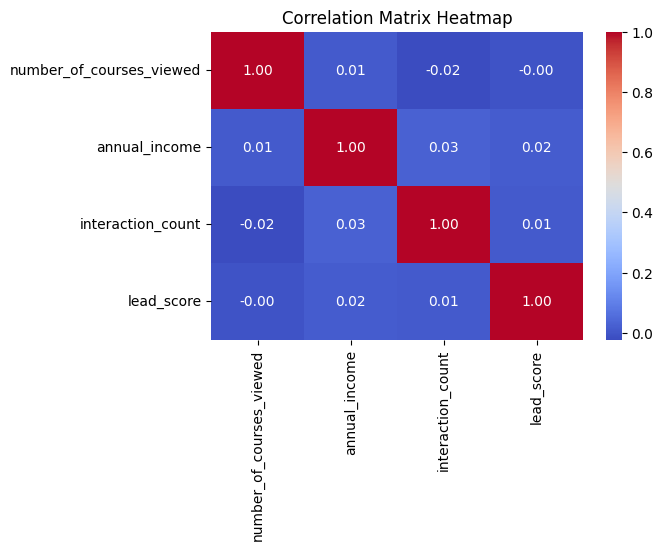

In [12]:
correlation_matrix = df[numerical].corr()
print(correlation_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)

(876, 293, 293)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [16]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [17]:
def mutual_info(series):
    return mutual_info_score(series, y_train)

score = df_train[categorical].apply(mutual_info).sort_values(ascending=False)   
round(score, 2)

lead_source          0.03
employment_status    0.02
industry             0.01
location             0.00
dtype: float64

In [18]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_full_train = dv.fit_transform(dicts_full_train)

In [19]:
y_full_train = df_full_train.converted.values

In [20]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [21]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_full_train, y_full_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [22]:
y_pred = model.predict_proba(X_test)[:, 1]
conv = (y_pred >= 0.5)

orig_score = (conv == y_test).mean()
round(orig_score, 2)

np.float64(0.74)

In [23]:
cat_without_industry = ['lead_source', 'employment_status', 'location']
cat_without_employment_status = ['lead_source', 'industry', 'location']
cat_without_lead_score = ['industry', 'employment_status', 'location']

In [24]:
scores = []
for cat in [cat_without_industry, cat_without_employment_status, cat_without_lead_score]:
    dicts_full_train = df_full_train[cat + numerical].to_dict(orient='records')
    
    dv = DictVectorizer()
    X_full_train = dv.fit_transform(dicts_full_train)
    
    y_full_train = df_full_train.converted.values
    
    dicts_test = df_test[cat + numerical].to_dict(orient='records')
    X_test = dv.transform(dicts_test)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_full_train, y_full_train)
    
    y_pred = model.predict_proba(X_test)[:, 1]
    conv = (y_pred >= 0.5)
    
    score = (conv == y_test).mean()
    scores.append(score)
scores

[np.float64(0.7372013651877133),
 np.float64(0.726962457337884),
 np.float64(0.726962457337884)]

In [25]:
differences = [orig_score - value for value in scores]
differences

[np.float64(0.0),
 np.float64(0.010238907849829282),
 np.float64(0.010238907849829282)]

In [26]:
for C in [0.01, 0.1, 1, 10, 100]:
        dicts_full_train = df_full_train[cat + numerical].to_dict(orient='records')
                
        dv = DictVectorizer()
        X_full_train = dv.fit_transform(dicts_full_train)
                
        y_full_train = df_full_train.converted.values
                
        dicts_test = df_test[cat + numerical].to_dict(orient='records')
        X_test = dv.transform(dicts_test)
                
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
        model.fit(X_full_train, y_full_train)
                
        y_pred = model.predict_proba(X_test)[:, 1]
        conv = (y_pred >= 0.5)
                
        score = (conv == y_test).mean()
        print(f'C={C}, score={round(score, 3)}')

C=0.01, score=0.73
C=0.1, score=0.73
C=1, score=0.727
C=10, score=0.727
C=100, score=0.727
